### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter

import spacy
from spacy import displacy
from spacy.matcher import Matcher

### Первоначальный анализ данных

In [2]:
df = pd.read_parquet('./europarl-ner.parquet', engine='pyarrow')
df.head()

,tokens,ner_tags
0,"[Resumption, of, the, session]","[0, 0, 0, 0]"
1,"[I, declare, resumed, the, session, of, the, E...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, ..."
2,"[Although, ,, as, you, will, have, seen, ,, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, ..."
3,"[You, have, requested, a, debate, on, this, su...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[In, the, meantime, ,, I, should, like, to, ob...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
print(f'Размер датафрейма: \n{df.shape}\n')
print(f'Типы данных: \n{df.dtypes}\n')
print(f'Пропущенные значения: \n{df.isna().sum()}\n')

Размер датафрейма: 
(799, 2)

Типы данных: 
tokens      object
ner_tags    object
dtype: object

Пропущенные значения: 
tokens      0
ner_tags    0
dtype: int64



Данные состоят из двух колонок:
* **tokens** - список строковых объектов
* **ner_tags** - список классификационных обозначений со следующими значениями: O (0), B-PER (1), I-PER (2), B-ORG (3), I-ORG (4), B-LOC (5), I-LOC (6), B-MISC (7), I-MISC (8)

Под обозначениями подразумевается:
* **B-метка (beginning)** - определяет начало сущности. К примеру, B-per означает начало ФИО человека (чаще всего имя)
* **I (inside)** – определяет слово в составе сущности. К примеру, I-per означает, что слово относится к ФИО человека, но это необязательно должно быть имя (или что в данных на 1-м месте)
* **O (outside)** – определяет любое неитересующее нас слово

В данных используются следующие теги:
* **O (Other)** — неинтересующее нас слово (пример: resumption, declare, the)
* **PER (Person)** — человек или группа людей (пример: Plooij-van Gorsel, Berenguer Fuster)
* **ORG (Organization)** — название организации, учебного заведения, органа государственной власти (пример: College of Quaestors, EU Member States)
* **LOC (Location)** - географический объект (пример: Sri Lanka, Indonesia)
* **MISC (Miscellaneous)** - прочая важная для контекста именованная сущность (пример: millennium, Australian, Finnish)

In [4]:
# преобразуем списки слов в строки

df.tokens = [' '.join(i) for i in df.tokens]

In [5]:
# создаем словарь с раскодировкой тегов

decoding_tags = { 
    0: 'O',
    1: 'PER', 
    2: 'PER',
    3: 'ORG',
    4: 'ORG',
    5: 'LOC',
    6: 'LOC',
    7: 'MISC',
    8: 'MISC'
}

In [6]:
# добавляем к датасету столбец с тегами в буквенном представлении (также без I, B)

encoded_tags = []

for i in range(len(df)):
    x = [decoding_tags[j] for j in pd.Series(df.ner_tags[i])]
    encoded_tags.append(x)

df['encoded_tags'] = encoded_tags

In [7]:
# смотрим получившейся датасет

df.head()

,tokens,ner_tags,encoded_tags
0,Resumption of the session,"[0, 0, 0, 0]","[O, O, O, O]"
1,I declare resumed the session of the European ...,"[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, ORG, ORG, O, O, O, O, O,..."
2,"Although , as you will have seen , the dreaded...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, MISC, MISC, ..."
3,You have requested a debate on this subject in...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"In the meantime , I should like to observe a m...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


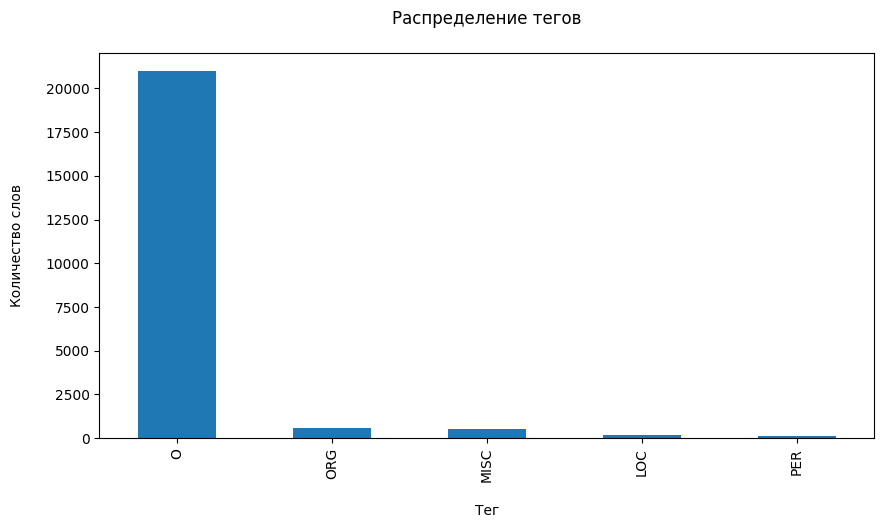

In [8]:
# смотрим распределение обновленных тегов

plt.figure(figsize=(10,5))
pd.Series(np.concatenate(df.encoded_tags)).value_counts().plot.bar()
plt.title('Распределение тегов\n')
plt.xlabel('\nТег')
plt.ylabel('Количество слов\n')
plt.show()

In [9]:
# смотрим распределение тегов в % соотношении

pd.Series(np.concatenate(df.encoded_tags)).value_counts(normalize=True).mul(100).round(2)

O       94.00
ORG      2.59
MISC     2.30
LOC      0.65
PER      0.46
Name: proportion, dtype: float64

По графику и полученному соотношению видно, что абсолютное большинство тегов приходится на неинтересующие нас слова. Почти одинокова частота встречаемости тегов типа **ORG** и **MISC**, практически отсутствуют теги **LOC** и **PER**

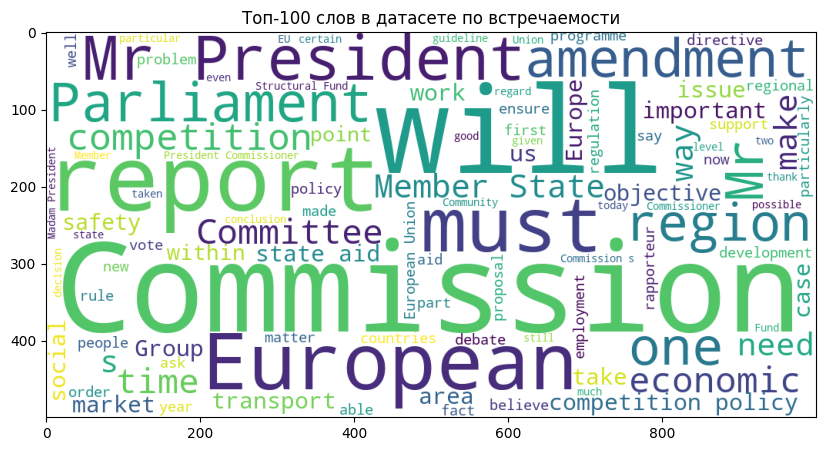

In [10]:
# смотрим самые часто встречающиеся слова

wordcloud = WordCloud(background_color='white', max_words=100, width=1000, height=500)
wordcloud.generate(' '.join(df.tokens))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Топ-100 слов в датасете по встречаемости')
plt.show()

Исходя из полученного топа наиболее часто встречаемых слов, можно сделать вывод, что датасет состоит из фрагментов текстов, написанных в официально-деловом и публицистическом стиле

### Rule-based подход для задачи NER

In [11]:
# загружаем предобученную модель

nlp = spacy.load("en_core_web_sm")
nlp

In [12]:
# смотрим работу модели на примере одного из фрагментов

doc = nlp(df.tokens[1])
print(f'Фрагмент: {doc}')
print(f'Сущности фрагмента: {doc.ents}')
print(f'Теги сущностей : {[i.label_ for i in doc.ents]}')

Фрагмент: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period .
Сущности фрагмента: (the European Parliament, Friday 17 December 1999, new year)
Теги сущностей : ['ORG', 'DATE', 'DATE']


In [13]:
# смотрим на определенные моделью сущности фрагмента с тегами

displacy.render(doc, style="ent") # вывод встреченных в фрагменте сущностей

### Оценка работы модели

Чтобы сравнить успешность определения сущностей фрагментов моделью, первоначально необходимо посмотреть на существующие в модели сущности

In [14]:
# существующие в модели сущности

ner = nlp.get_pipe('ner')
i = 0

print('Сущности модели:')
for label in ner.labels:
    i += 1
    print(f'{i}. {label} — {spacy.explain(label)}')

Сущности модели:
1. CARDINAL — Numerals that do not fall under another type
2. DATE — Absolute or relative dates or periods
3. EVENT — Named hurricanes, battles, wars, sports events, etc.
4. FAC — Buildings, airports, highways, bridges, etc.
5. GPE — Countries, cities, states
6. LANGUAGE — Any named language
7. LAW — Named documents made into laws.
8. LOC — Non-GPE locations, mountain ranges, bodies of water
9. MONEY — Monetary values, including unit
10. NORP — Nationalities or religious or political groups
11. ORDINAL — "first", "second", etc.
12. ORG — Companies, agencies, institutions, etc.
13. PERCENT — Percentage, including "%"
14. PERSON — People, including fictional
15. PRODUCT — Objects, vehicles, foods, etc. (not services)
16. QUANTITY — Measurements, as of weight or distance
17. TIME — Times smaller than a day
18. WORK_OF_ART — Titles of books, songs, etc.


Данные состоят из двух колонок:
* **tokens** - список строковых объектов
* **ner_tags** - список классификационных обозначений со следующими значениями: O (0), B-PER (1), I-PER (2), B-ORG (3), I-ORG (4), B-LOC (5), I-LOC (6), B-MISC (7), I-MISC (8)

In [15]:
# создаем словарь с соотношением изначальных тегов с соответствующими тегами модели

based_to_spacy = { 
    0: 'O',
    1: 'PERSON', 
    2: 'PERSON',
    3: 'ORG',
    4: 'ORG', 
    5: 'GPE',
    6: 'GPE',
    7: 'MISC',
    8: 'MISC'
}

Для дальнейшего сравнения необходимо создать два списка: **базовые сочетания слов и тегов** и **предсказанные моделью сочетания**

In [16]:
# создаем списки слов и ожидаемых для них тегов 

words = []
tags = []

for i in range(len(df)):
    words.append([word for word in pd.Series(df.tokens[i].split(' '))])

for i in range(len(df)):
    tags.append([based_to_spacy[tag] for tag in pd.Series(df.ner_tags[i])])

In [17]:
# формируем окончательный список базовых сущностей

based_tags = []

for i in range(len(words)):
    based_tags.append([])

    for j in range(len(words[i])):
        if tags[i][j] != 'O':
            based_tags[i].append((words[i][j], tags[i][j]))

based_tags[:5]

[[],
 [('European', 'ORG'), ('Parliament', 'ORG')],
 [('millennium', 'MISC'), ('bug', 'MISC')],
 [],
 [('European', 'ORG'), ('Union', 'ORG')]]

In [18]:
# формируем список сущностей, определенных spacy моделью

spacy_tags = []

for i in range(len(df)):
    spacy_tags.append([]) 
    doc = nlp(df.tokens[i])
    
    for entity in doc.ents:
        entity_words = entity.text.split()

        for word in entity_words:
            spacy_tags[i].append((word, entity.label_))

spacy_tags[:5]

[[],
 [('the', 'ORG'),
  ('European', 'ORG'),
  ('Parliament', 'ORG'),
  ('Friday', 'DATE'),
  ('17', 'DATE'),
  ('December', 'DATE'),
  ('1999', 'DATE'),
  ('new', 'DATE'),
  ('year', 'DATE')],
 [],
 [('the', 'DATE'), ('next', 'DATE'), ('few', 'DATE'), ('days', 'DATE')],
 [('the', 'ORG'), ('European', 'ORG'), ('Union', 'ORG')]]

Оценивать работу модели мы будем при помощи метрики **Accuracy**, что представляет собой частное количества слов/сущностей, которые модель определила верно, и количества слов/сущностей, что модель вовсе не идентифицировала или результат отличен от ожидаемого

In [19]:
# создаем функцию для расчета средних Accuracy

def accuracy(based_tags, spacy_tags):
    coincidences_words = []
    coincidences_with_tags = []

    for i in range(len(based_tags)):
        words_expected = set([tag[0] for tag in based_tags[i]])
        words_predicted = set([tag[0] for tag in spacy_tags[i]])
        intersection_words = words_expected.intersection(words_predicted)

        with_tags_expected = set(based_tags[i])
        with_tags_predicted = set(spacy_tags[i])
        intersection_with_tags = with_tags_expected.intersection(with_tags_predicted)

        try:
            coincidences_words.append(len(intersection_words) / len(words_predicted))
        except ZeroDivisionError:
            if len(words_expected):
                coincidences_words.append(0)
            else:
                coincidences_words.append(1)
        
        try:
            coincidences_with_tags.append(len(intersection_with_tags) / len(with_tags_expected)) 
        except ZeroDivisionError:
            if len(with_tags_expected) > 0:
                coincidences_with_tags.append(0)
            else: 
                coincidences_with_tags.append(1)
    
    return round(sum(coincidences_words) / len(coincidences_words), 2), round(sum(coincidences_with_tags) / len(coincidences_with_tags), 2)

In [20]:
# проверяем работу функции

accuracy(based_tags, spacy_tags)

(0.7, 0.75)

Предсказательная сила модели фреймворка `spacy` по метрике **Accuracy** равна 70% для слов и 75% для слов с тегом (сущностей). При этом не следует забывать, что мы учитывали определение моделью сущностей, которые уже были выявлены в датасете. Другие слова и сущности, которых, например, в `spacy` гораздо больше (18) - мы не рассматривали. Говоря про полученное значение метрики, можно утверждать, что в принципе это хороший результат, но ведь нет предела совершенству

### Проблемные фрагменты

Определим фрагменты, сущности которых модель не определила в полной мере или определила иначе, чем в самом датасете

In [21]:
# создадим функцию для определения индексов проблемных фрагментов (со словами)

def problem_words(based_tags, spacy_tags):
    coincidences = []

    for i in range(len(based_tags)):
        words_expected = set([tag[0] for tag in based_tags[i]])
        words_predicted = set([tag[0] for tag in spacy_tags[i]])
        intersection_words = words_expected.intersection(words_predicted)
        
        try:
            coincidences.append(len(intersection_words) / len(words_expected))

        except ZeroDivisionError:
            if len(words_expected) > 0:
                coincidences.append(0)
            else:
                coincidences.append(1)
    
    problem_fragments = (pd.Series(coincidences) < 1) \
        .reset_index() \
        .rename(columns=({0: 'detected'})) \
        .query('detected == True') \
        .reset_index(drop=True) \
        [['index']]
    
    return problem_fragments

In [22]:
# проверяем работу функции

index_words = problem_words(based_tags, spacy_tags)
print(f'Количество проблемных фрагментов: {len(index_words)}')
print(f'Пример индекса проблемного фрагмента: {index_words.loc[3]["index"]}')

Количество проблемных фрагментов: 142
Пример индекса проблемного фрагмента: 35


In [23]:
# создадим функцию для определения индексов проблемных фрагментов (с тегами)

def problem_tags(based_tags, spacy_tags):
    coincidences = []

    for i in range(len(based_tags)):
        tags_expected = set(based_tags[i])
        tags_predicted = set(spacy_tags[i])
        intersection_tags = tags_expected.intersection(tags_predicted)
        
        try:
            coincidences.append(len(intersection_tags) / len(tags_expected))

        except ZeroDivisionError:
            if len(tags_expected) > 0:
                coincidences.append(0)
            else: 
                coincidences.append(1)

    problem_fragments = (pd.Series(coincidences) < 1) \
        .reset_index() \
        .rename(columns=({0: 'detected'})) \
        .query('detected == True') \
        .reset_index(drop=True) \
        [['index']]
    
    return problem_fragments

In [24]:
# проверяем работу функции

index_tags = problem_tags(based_tags, spacy_tags)
print(f'Количество проблемных фрагментов: {len(index_tags)}')
print(f'Пример индекса проблемного фрагмента: {index_tags.loc[3]["index"]}')

Количество проблемных фрагментов: 242
Пример индекса проблемного фрагмента: 24


In [25]:
# создаем и объединяем два датасета с сущностями проблемных фрагментов для дальнейшего сравнения

index_tags_list = index_tags['index'].tolist()

df_based_tags = pd.DataFrame({'based_tags': []})
df_based_tags['based_tags'] = df_based_tags['based_tags'].astype('object')

df_spacy_tags = pd.DataFrame({'spacy_tags': []})
df_spacy_tags['spacy_tags'] = df_spacy_tags['spacy_tags'].astype('object')

for i in range(len(index_tags_list)):
    df_based_tags.at[i, 'based_tags'] = based_tags[index_tags_list[i]]

for i in range(len(index_tags_list)):
    df_spacy_tags.at[i, 'spacy_tags'] = spacy_tags[index_tags_list[i]]

index_tags['based_tags'] = df_based_tags['based_tags']
index_tags['spacy_tags'] = df_spacy_tags['spacy_tags']

In [26]:
# рассмотрим получившуюся таблицу

index_tags.head()

,index,based_tags,spacy_tags
0,2,"[(millennium, MISC), (bug, MISC)]",[]
1,10,"[(Sri, MISC), (Lankan, MISC), (Parliament, ORG...","[(Madam, PERSON), (Parliament, ORG), (Sri, GPE..."
2,17,"[(European, ORG), (Parliament, ORG), (Texas, G...","[(this, DATE), (year, DATE), (', DATE), (s, DA..."
3,24,"[(European, MISC), (Barents, GPE), (Sea, GPE),...","[(European, NORP), (the, LOC), (Barents, LOC),..."
4,28,"[(Finnish, MISC), (Portuguese, MISC), (Dutch, ...","[(two, CARDINAL), (Finnish, NORP), (one, CARDI..."


Можно увидеть, что модель не определяет слова с тегом `MISC` или присваивает им другой тег `NORP`(Nationalities or religious or political groups). Также модель в некоторых случаях не определяет человека по имени (`PERSON`), иначе идентифицирует географические объекты (`LOC` вместо `GPE`) и бывает игнорирует полное название организаций (`ORG`)

### Новые правила

На этом этапе мы определим дополнительные правила определения сущностей и присвоения им соответствующих тегов

In [27]:
# определяем слова с тегом MISC и смотрим 15 наиболее популярных из них

words_MISC = []

for i in range(len(based_tags)):
    for j in range(len(based_tags[i])):
        if (based_tags[i][j][1] == 'MISC'):
            words_MISC.append(based_tags[i][j][0])

pd.Series(words_MISC).value_counts(ascending=False).head(15)

European       42
policy         29
competition    23
Funds          19
Structural     16
report         14
1999           13
/              13
Union          12
s              11
'              11
on             11
the            11
Fund           10
Cohesion        9
Name: count, dtype: int64

In [28]:
# определяем словосочетания с MISC и смотрим наиболее популярные из них

phrases_MISC = []

for i in range(len(df)):
    phrase = ''
    for j in range(len(df['encoded_tags'][i])):
        if df['encoded_tags'][i][j] == 'MISC':
            phrase += df['tokens'][i].split()[j] + ' '
    if phrase != '':
        phrases_MISC.append(phrase.strip())

Counter(phrases_MISC)

Counter({'European': 17,
         'Structural Funds': 7,
         'European competition policy': 5,
         'steel aid code': 5,
         'competition policy': 5,
         'Objective 1': 4,
         'Structural Cohesion Funds': 3,
         'sixth periodic report': 3,
         'Treaties': 2,
         'Erika': 2,
         'European Social Fund': 2,
         'Social Fund': 2,
         'regional policy': 2,
         'structural funds': 2,
         'structural policy': 2,
         'parliamentary': 2,
         'Treaty': 2,
         'Jonckheer report': 2,
         "European Union ' s competition policy": 2,
         'Community competition law': 2,
         'millennium bug': 1,
         'Sri Lankan': 1,
         'Finnish Portuguese Dutch Dutch': 1,
         'Dutch': 1,
         'Spanish': 1,
         'ABC newspaper': 1,
         'Austrian': 1,
         'European law': 1,
         'ADR': 1,
         'ISO 9002': 1,
         'Eastern European': 1,
         'acquis communautaire': 1,
         '95

In [29]:
# определяем слова с тегом ORG и смотрим 15 наиболее популярных из них

words_ORG = []

for i in range(len(based_tags)):
    for j in range(len(based_tags[i])):
        if (based_tags[i][j][1] == 'ORG'):
            words_ORG.append(based_tags[i][j][0])

pd.Series(words_ORG).value_counts(ascending=False).head(15)

Commission    113
Parliament     59
European       41
Union          40
Member         31
States         31
Committee      20
and            18
on             17
of             15
EU             15
Group          11
Affairs        11
Council         9
Economic        9
Name: count, dtype: int64

In [30]:
# определяем словосочетания с ORG и смотрим наиболее популярные из них

phrases_ORG = []

for i in range(len(df)):
    phrase = ''
    for j in range(len(df['encoded_tags'][i])):
        if df['encoded_tags'][i][j] == 'ORG':
            phrase += df['tokens'][i].split()[j] + ' '
    if phrase != '':
        phrases_ORG.append(phrase.strip())

Counter(phrases_ORG)

Counter({'Commission': 59,
         'Parliament': 23,
         'Member States': 15,
         'Union': 15,
         'EU': 12,
         'European Union': 11,
         'European Parliament': 7,
         'Commission Parliament': 7,
         'House': 6,
         'Council': 6,
         'Commission Commission': 4,
         'CEN': 4,
         'Community': 4,
         'Commission Member States': 4,
         'Committee on Economic and Monetary Affairs': 4,
         'Committee on Employment and Social Affairs': 3,
         'European Commission': 3,
         'Commission Commission Parliament': 2,
         'PPE-DE Group': 2,
         'Member States Commission': 2,
         'Health and Safety Committee': 1,
         'College of Quaestors': 1,
         'Parliament Parliament': 1,
         'EU Member States': 1,
         'Prodi Commission Group of the Party of European Socialists Conference of Presidents': 1,
         'Parliament Commission': 1,
         'Conference of Presidents Commission': 1,
     

In [31]:
# определяем слова с тегом PERSON и смотрим 15 наиболее популярных из них

words_PERSON = []

for i in range(len(based_tags)):
    for j in range(len(based_tags[i])):
        if (based_tags[i][j][1] == 'PERSON'):
            words_PERSON.append(based_tags[i][j][0])

pd.Series(words_PERSON).value_counts(ascending=False).head(15)

Koch          9
von           6
Monti         5
Wogau         5
Jonckheer     5
Schroedter    4
Rapkay        4
de            3
Berenguer     3
Evans         3
Duisenberg    3
Palacio       3
Poettering    2
Prodi         2
Berend        2
Name: count, dtype: int64

In [32]:
# определяем словосочетания с PERSON и смотрим наиболее популярные из них

phrases_PERSON = []

for i in range(len(df)):
    phrase = ''
    for j in range(len(df['encoded_tags'][i])):
        if df['encoded_tags'][i][j] == 'PER':
            phrase += df['tokens'][i].split()[j] + ' '
    if phrase != '':
        phrases_PERSON.append(phrase.strip())

Counter(phrases_PERSON)

Counter({'Koch': 9,
         'Monti': 5,
         'von Wogau': 4,
         'Jonckheer': 4,
         'Evans': 3,
         'Rapkay': 3,
         'Schroedter': 2,
         'Lynne': 2,
         'de Palacio': 2,
         'Prodi': 2,
         'Poettering': 2,
         'Duisenberg': 2,
         'Berenguer': 2,
         'Kumar Ponnambalam': 1,
         'Hicks': 1,
         'Segni': 1,
         'Alexander Nikitin': 1,
         'Plooij-van Gorsel': 1,
         'Díez González de Palacio': 1,
         'Berenguer Fuster': 1,
         'Wurtz': 1,
         'Barón Crespo': 1,
         'Cox Hänsch': 1,
         'Simpson': 1,
         'Rack Swoboda': 1,
         'Ari Vatanen': 1,
         'Vatanen': 1,
         'Swoboda': 1,
         'Schroedter Flautre': 1,
         'Flautre': 1,
         'Hague Wulf-Mathies': 1,
         'McCarthy': 1,
         'Bernié': 1,
         'Schroedter Berend': 1,
         'Berend': 1,
         'Cox': 1,
         'Wynn': 1,
         'Ahern': 1,
         'von Wogau Langen Rapk

In [33]:
# определяем слова с тегом GPE и смотрим 15 наиболее популярных из них

words_LOC = []

for i in range(len(based_tags)):
    for j in range(len(based_tags[i])):
        if (based_tags[i][j][1] == 'GPE'):
            words_LOC.append(based_tags[i][j][0])

pd.Series(words_LOC).value_counts(ascending=False).head(15)

Europe       33
Wales         6
of            5
European      5
Germany       5
Sri           3
Austria       3
Eastern       3
Lanka         3
buildings     2
Central       2
Kingdom       2
United        2
America       2
Russia        2
Name: count, dtype: int64

In [34]:
# определяем словосочетания с GPE и смотрим наиболее популярные из них

phrases_GPE = []

for i in range(len(df)):
    phrase = ''
    for j in range(len(df['encoded_tags'][i])):
        if df['encoded_tags'][i][j] == 'LOC':
            phrase += df['tokens'][i].split()[j] + ' '
    if phrase != '':
        phrases_GPE.append(phrase.strip())

Counter(phrases_GPE)

Counter({'Europe': 22,
         'Wales': 5,
         'Sri Lanka': 3,
         'Europe Europe': 3,
         'Austria': 2,
         'East Germany': 2,
         'Basque Country': 2,
         'Texas America': 1,
         'Russia': 1,
         'Barents Sea Russia': 1,
         'Brussels Parliament buildings Strasbourg Parliament buildings': 1,
         'Indonesia Indonesia': 1,
         'Tauern Tunnel': 1,
         'EU': 1,
         'Belgium the Netherlands': 1,
         'Eastern Europe': 1,
         'Belgium Finland Japan': 1,
         'Sweden Germany Italy Austria': 1,
         'Community': 1,
         'Lapland': 1,
         'European Union': 1,
         'United Kingdom Wales': 1,
         'Principality': 1,
         'UK': 1,
         'Europe of Citizens Europe of States and of Regions': 1,
         'Italy': 1,
         'United Kingdom West Midlands': 1,
         'European mainland': 1,
         'islands of the Azores Madeira': 1,
         'French overseas departments': 1,
         'Commu

Определенные выше словосочетания не совсем корректны, так как могут включать в себя повторяющиеся значения. Это некритично, и все равно показанные словосочетания позволяют определить наиболее часто употребляемые словосочетания. Исходя из них сформируем свои правила для модели

In [35]:
matcher = Matcher(nlp.vocab)

# правило для определения прочих важных для контекста именованных сущностей (MISC)
patterns_misc = []
patterns_misc.append([{'TEXT': {'IN': ["Structural Funds", "European competition policy", "steel aid code", "competition policy", "Objective 1", "Structural Cohesion Funds",
                                        "sixth periodic report", "Treaties", "Erika", "Social Fund", "regional policy", "structural funds", "structural policy",
                                        "parliamentary", "Treaty", "Jonckheer report", "European Union ' s competition policy", "Community competition law"]}}])
matcher.add("MISC", patterns_misc)

# правило для определения полных названий организаций (ORG)
patterns_org = []
patterns_org.append([{'TEXT': {'IN': ["European", "Commission", "Parliament", "Member States", "Union", "EU", "European Union", "Commission Parliament", "House",
                                      "Council", "CEN", "Community", "Commission Member States", "Committee on Economic and Monetary Affairs",
                                      "Committee on Employment and Social Affairs", "European Commission", "PPE-DE Group", "Member States Commission"]}}])
matcher.add("ORG", patterns_org)

# правило для определения имен людей (PERSON)
patterns_person = []
patterns_person.append([{'TEXT': {'IN': ["Koch", "Monti", "von Wogau", "Jonckheer", "Evans", "Rapkay", "Schroedter",
                                         "Lynne", "de Palacio", "Prodi", "Poettering", "Duisenberg", "Berenguer"]}}])
matcher.add("PERSON", patterns_person)

# правило для определения локаций (GPE)
patterns_gpe = []
patterns_gpe.append([{'TEXT': {'IN': ["Europe", "Wales", "Sri Lanka", "Austria", "East Germany", "Basque Country",
                                      "Texas", "Russia", "Barents Sea", "Austria", "Indonesia", "Tauern Tunnel",
                                      "EU", "UK", "United Kingdom", "Ireland", "Brandenburg"]}}])
matcher.add("GPE", patterns_gpe)

### Расчет метрик обновленной модели

In [36]:
# создаем список новых сущностей, получившихся в ходе работы модели по новым правилам

new_entities = []

for i in (range(len(df))):
    new_entities.append([])
    doc = nlp(df.tokens[i])
    matches = matcher(doc)

    for entity_id, start, end in matches:
        entity = doc[start:end].text.split()
        for word in entity:
            new_entities[i].append((word, nlp.vocab.strings[entity_id]))

new_entities[:5]

[[],
 [('European', 'ORG'), ('Parliament', 'ORG')],
 [],
 [],
 [('European', 'ORG'), ('Union', 'ORG')]]

In [37]:
# получаем новые знчения метрик

accuracy(based_tags, new_entities)

(0.85, 0.73)

Среднее значение метрики **Accurancy** по словам заметно увеличилось (+15%), но при этом в определении сущностей показатель немного упал (-2%). Такой результат мы получили в силу большого количества словосочетаний и отдельных слов, частота встречаемости которых крайне мала. При желании можно добавлять их по отдельности или придумать оригинальное правило с использованием регулярных выражений

### Вывод

Rule-Based подход показал неплохие результаты в применении модели `spacy`. Сама по себе модель правильно определяла слова и сущности в более чем 70% случаев. За счет добавления новых правил получилось улучшить целевую метрику по идентификации слов и несильно проиграть в определении сущностей. При этом важно понимать, что при увеличении количества и вариативности данных будет нарастать потребность в дополнении существующих правил